### Max-Cut problem

Max-Cut es un problema de teoría de grafos que consiste en particionar un grafo separando los vértices en dos subconjuntos disjuntos de manera tal, que el número de aristas que contengan un vértice de cada conjunto sea máximo. 

En este tutorial vamos a ver:
 - Entender el problema Max-Cut con un ejemplo.
 - Cómo formular Mux-Cut como un problema QUBO.
 - Resolver el Max-Cut utilizando el algoritmo QAOA.


Un grafo $G$ es un par ordenado $(V,E)$ donde $V$ es un conjunto de vértices y $E$ es un conjunto de aristas que unen esos vértices y cuyos elementos se representan como pares de elementos tomados de V.

El siguiente es un ejemplo de grafo sobre el que vamos a trabajar para entender el problema Max-Cut.

Sea $V = \{A, B, C, D\}$ el conjunto de vértices y $E = \{(A, B), (B, C), (C, D), (D, A)\}$ el conjunto de aristas que unen esos vértices.

Visualicemos el grafo.

Conjunto de Vértices: ['A', 'B', 'C', 'D']
Conjunto de Aristas: [('A', 'B'), ('A', 'D'), ('B', 'C'), ('C', 'D')]


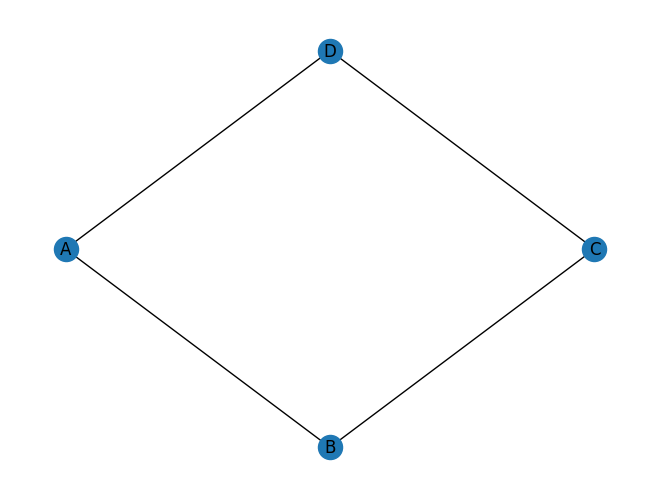

In [76]:
import matplotlib.pyplot as plt
import networkx as nx

graph = nx.Graph()

# Conjunto de vértices
V = ["A", "B", "C", "D"]
# Conjunto de aristas 
E = [("A", "B"), ("B", "C"), ("C", "D"), ("D", "A")]

graph.add_nodes_from(V) # Añadimos los nodos al grafo
graph.add_edges_from(E) # Añadimos las aristas al grafo

print(f"Conjunto de Vértices: {graph.nodes}")
print(f"Conjunto de Aristas: {graph.edges}")

nx.draw_shell(graph, with_labels=True)

Supongamos que hacemos la siguiente $\textbf{partición}$ $V_1=\{A,B\}$ y $V_2=\{C,D\}$ que cumple las condiciones $V_1 \cup V_2 = V$ y $V_1 \cap V_2 = \varnothing$. Es decir, $V_1$ y $V_2$ son complementarios en $V$.

Dibujemos el grafo con los colores rojo para los vértices de $V_1$ y azul para los vértices de $V_2$.

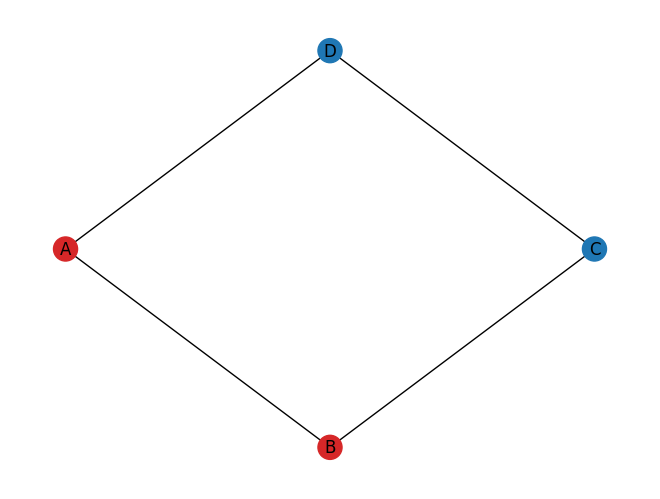

In [72]:
nx.draw_shell(graph, with_labels=True, node_color=["tab:red" if n in ("A", "B") else "tab:blue" for n in graph])

Vamos a formar un conjunto con las aristas que tienen un vértice rojo y otro vértice azul $S = \{(A,D), (B,C)\} \subset E$, a este conjunto lo vamos a llamar $\textbf{corte}$ y al número de elementos que contiene $|S|=2$ lo llamaremos $\textbf{valor del corte}$.

¿Podemos encontrar otra partición del conjunto $V$ de tal manera que el valor $|S|$ se mayor que 2?

Para responder a esta pregunta vamos a considerar la siguiente partición: $V_1 = \{A,C\}$ y $V_2 = \{B,D\}$ y visualicemos cómo nos queda el grafo.

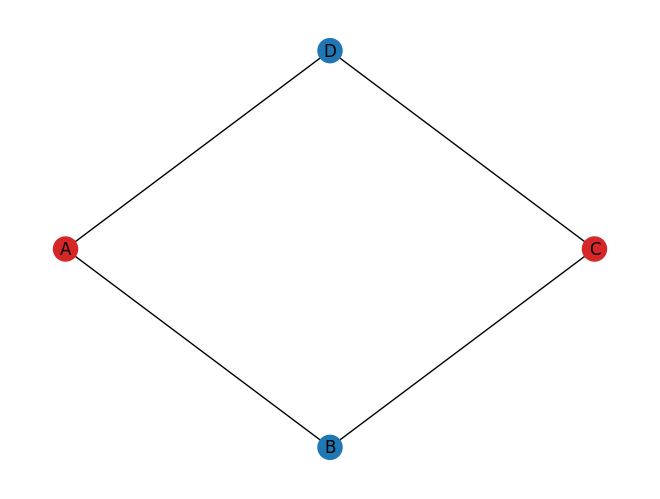

In [78]:
nx.draw_shell(graph, with_labels=True, node_color=["tab:red" if n in ("A", "C") else "tab:blue" for n in graph])

Construimos ahora el corte $S$ formado por las aristas que tienen distinto color $S = \{(A,B), (B,C), (C,D), (D,A)\} = E$ y su valor de corte es $|S| = 4$, siendo éste el máximo valor que podemos alcanzar ya que no hay más aristas. Hemos alcanzado el máximo corte.

En esto consiste el problema Max-Cut, dado un grafo $G(V,E)$ encontrar un corte $S \subseteq E$ tal que $|S|$ sea el máximo posible.

### Formulación QUBO

En el apartado anterior hemos visto cómo resolver el problema Max-Cut con un grafo de cuatro vértices pero ¿y si el grafo tuviera 500 vértices? Sería mucho más complicado resolverlo a mano. En este apartado utilizaremos la formulación QUBO (Quadratic Unconstrained Binary Optimization) 

Para ello, utilizaremos el grafo con el primer corte que hicimos pero usando números naturales para etiquetar los vértices.

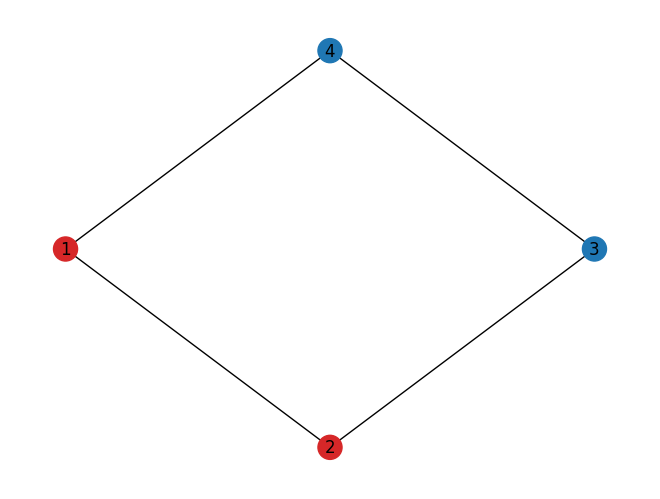

In [42]:
number_graph = nx.Graph([(1, 2), (2, 3), (3, 4), (4, 1)])

nx.draw(number_graph,
        pos=nx.shell_layout(number_graph),
        with_labels=True,
        node_color=["tab:red" if n in (1,2) else "tab:blue" for n in number_graph])

Nuestro objetivo ahora es encontrar una función $C(x_1, x_2, x_3, x_4)$ que recibe cuatro variables binarias que representan una partición del grafo y nos devuelve el valor del corte.

Usamos cuatro variables porque estamos trabajando con un grafo de cuatro vértices, si nuestro grafo tuviera n vértices necesitaríamos n variables.

Observando el grafo anterior vemos que las variables toman los siguientes valores $x_1 = x_2 = 1$ (ROJO) y $x_3 = x_4 = 0$ (AZUL).

La partición viene representada por el vector $\vec{x} = (x_1,x_2,x_3,x_4) = (1,1,0,0)$ y puesto que el corte de ese grafo es 2 tenemos que $C(1,1,0,0) = 2$.

Nuestro primer objetivo es determinar si una arista tiene un vértice de color rojo y otro de color azul. 

Podemos probar sumando ambos valores de las variables de cada vértice:

$$
\begin{align*}
x_1 + x_4 = 1 + 0 = 1 \\
x_2 + x_3 = 1 + 0 = 1 \\
x_1 + x_2 = 1 + 1 = 2 \\
x_3 + x_4 = 0 + 0 = 0
\end{align*}
$$

Este método funciona bien para saber si una arista tiene un vértice de cada color, ambos de color rojo o ambos de color azul pero no nos ayuda a calcular el máximo corte.

Probemos multiplicando:

$$
\begin{align*}
x_1 · x_4 = 1 · 0 = 0 \\
x_2 · x_3 = 1 · 0 = 0 \\
x_1 · x_2 = 1 · 1 = 1 \\
x_3 · x_4 = 0 · 0 = 0
\end{align*}
$$

Ahora solo podemos saber cuándo dos aristas son rojas, lo cual no nos ayuda mucho. Vamos a hacerle una pequeña variación a la multiplicación y restemos a 1 el valor de la variable de la derecha:

$$
\begin{align*}
x_1 · (1 - x_4) = 1 · (1 - 0) = 1 \\
x_2 · (1 - x_3) = 1 · (1 - 0) = 1 \\
x_1 · (1 - x_2) = 1 · (1 - 1) = 0 \\
x_3 · (1 - x_4) = 0 · (1 - 0) = 0
\end{align*}
$$

Este cálculo si es prometedor, hemos definido una función $f(x_i, x_j) = x_i·(1-x_j)$ que dados dos vértices nos devuelve 1 si ambos vértices son de distinto color y 0 si son del mismo color y además podemos calcular el corte del grafo sumando todos los términos. Parece que vamos en buen camino de encontrar una fórmula para calcular el máximo corte.

Podríamos encontrar una pega a la fórmula anterior ya que $f(x_4, x_1) = x_4 · (1 - x_1) = 0 · (1 - 1) = 0$ y la arista $(4,1)$ tiene vértices de distinto color. Sin embargo, pronto veremos que esto no supone ningún problema.

Definamos la siguiente función:

$$
\begin{align*}
C(x_1, x_2, x_3, x_4) = \sum_{i=1}^{4} \sum_{j=1}^{4} x_i·(1 - x_j) & = x_1·(1-x_1) + x_1·(1-x_2) + x_1·(1-x_3) + x_1·(1-x_4) + \\
& + x_2·(1-x_1) + x_2·(1-x_2) + x_2·(1-x_3) + x_2·(1-x_4) + \\
& + x_3·(1-x_1) + x_3·(1-x_2) + x_3·(1-x_3) + x_3·(1-x_4) + \\
& + x_4·(1-x_1) + x_4·(1-x_2) + x_4·(1-x_3) + x_4·(1-x_4) 
\end{align*}
$$

Hemos construido una función que a una partición de un grafo nos devuelve el corte de esa partición:

$$C: \{0,1\}^4 \rightarrow \mathbb{Z}$$  

Vamos a analizar algunos términos de la función anterior a ver si tenemos que modificarla.

Existen tres tipos de términos en la suma anterior:
 - Los términos no nulos y legítimos $x_1·(1-x_4)$ y $x_2·(1-x_3)$ ambos valen 1.
 - Los términos nulos, que son la gran mayoría de ellos. Son los términos de la diagonal, los recíprocos de los anteriores y los correspondientes a los vértices del mismo color.
 - Los términos fantasma, son los correspondientes a aristas que no existen.

De todos ellos los que más nos fastidian son los términos fantasma, que son cuatro:

$$
\begin{align*}
x_1·(1-x_4) = 1 \\
x_2·(1-x_3) = 1 \\
x_4·(1-x_1) = 0 \\
x_3·(1-x_2) = 0
\end{align*}
$$

Vemos que estos términos aportan un valor de 2 a la suma, obteniendo un total de 4 para la partición dada que no es el valor correcto.

Para corregir esto introduciremos unos pesos $w_{ij}$ que valen 1 si entre los vértices i y j hay una arista y 0 en caso contrario. 

Para el grafo con el que estamos trabajando tenemos $w_{12} = w_{21} = w_{23} = w_{32} = w_{34} = w_{43} = w_{14} = w_{41} = 1$, el resto de coeficientes son 0.

Podemos simplificar la fórmula anterior:

$$
\begin{align*}
C(x_1, x_2, x_3, x_4) = \sum_{i=1}^{4} \sum_{j=1}^{4} w_{ij}x_i·(1 - x_j) & = w_{11}·x_1·(1-x_1) + w_{12}·x_1·(1-x_2) + w_{13}·x_1·(1-x_3) + w_{14}·x_1·(1-x_4) + \\
& + w_{21}·x_2·(1-x_1) + w_{22}·x_2·(1-x_2) + w_{23}·x_2·(1-x_3) + w_{24}·x_2·(1-x_4) + \\
& + w_{31}·x_3·(1-x_1) + w_{32}·x_3·(1-x_2) + w_{33}·x_3·(1-x_3) + w_{34}·x_3·(1-x_4) + \\
& + w_{41}·x_4·(1-x_1) + w_{42}·x_4·(1-x_2) + w_{43}·x_4·(1-x_3) + w_{44}·x_4·(1-x_4)   \\
\end{align*}
$$

Eliminando los términos que tienen pesos nulos y simplificando nos queda:

$$
\begin{align*}
C(x_1, x_2, x_3, x_4) & = x_1·(1-x_2) + x_1·(1-x_4) + x_2·(1-x_1) + x_2·(1-x_3) + x_3·(1-x_2) + x_3·(1-x_4) + x_4·(1-x_1) + x_4·(1-x_3) \\
                      & = [x_1·(1-x_2) + x_2·(1-x_1)] + [x_2·(1-x_3) + x_3·(1-x_2)] + [x_3·(1-x_4) + x_4·(1-x_3)] + [x_4·(1-x_1) + x_1·(1-x_4)] \\
                      & = \sum_{(ij)} x_i·(1-x_j) + x_j·(1-x_i) \\
                      & = \sum_{(ij)} x_i + x_j -2x_ix_j
\end{align*}
$$




Téngase en cuenta que el sumatorio obtenido significa sumar para todas las aristas del grafo.

En la formulación QUBO el problema Max-Cut consiste en encontrar el máximo de la función anterior, para el caso de n vértices sería:

$$
\max_{x \in \{0,1\}^n} \sum_{(ij)} x_i + x_j -2x_ix_j
$$

### Algoritmo QAOA

En proceso ...

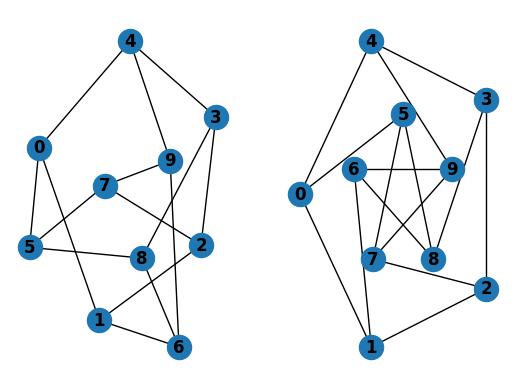

In [39]:
G = nx.petersen_graph()
subax1 = plt.subplot(121)
nx.draw(G, with_labels=True, font_weight='bold')
subax2 = plt.subplot(122)
nx.draw_shell(G, nlist=[range(5, 10), range(5)], with_labels=True, font_weight='bold')